# Excursus on scaling

Links to Data Analytics 1 material on normalization and scaling:

* [normalization types](https://colab.research.google.com/drive/12RTxw-M7fVDKP76GOBMlyGGRxzff2pBd#scrollTo=of4pTiu9mPwe)

* [reasons for normalization](https://colab.research.google.com/drive/16mBQnojpVWiCVKwO2DhOK8cg1BDCrQRd#scrollTo=7-PzECxOdz5G)

Refresher on how scaling is particularly important for distance-based models.

## Inches vs centimeters

Same heights in inches vs cm will result in different clustering, which they shouldn't of course.

*(Example from Joel Grus: Data Science From Scratch.)*

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df_abc = pd.DataFrame([[63,160,150],
                    [67,170.2,160],
                    [70,177.8,171]], \
                  columns=["height_in", "height_cm", "weight_pounds"], index=["Ann", "Bob", "Cecil"])
df_abc

,height_in,height_cm,weight_pounds
Ann,63,160.0,150
Bob,67,170.2,160
Cecil,70,177.8,171


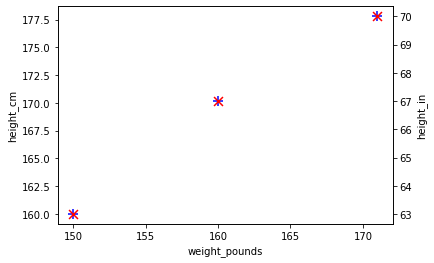

In [ ]:
## to show that we indeed have the exact same heights in cm and in
ax = df_abc.plot.scatter("weight_pounds", "height_cm", marker="+", s=100, sharex=False, c="b");
ax2 = ax.twinx()
df_abc.plot.scatter("weight_pounds", "height_in", marker="x", s=80, sharex=False, c="r", ax=ax2);

Let's see what we get with non-normalized K-means clustering on the height-weight space...

* We now plot each space with *equal* aspect to see what a distance-based model actually sees.

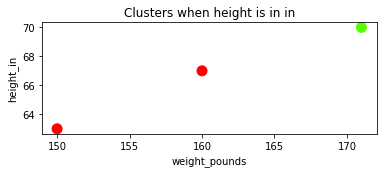

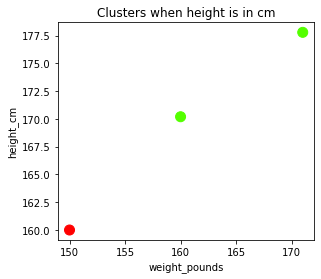

,height_in,height_cm,weight_pounds,"cluster (pound, in)","cluster (pound, cm)"
Ann,63,160.0,150,0,0
Bob,67,170.2,160,0,1
Cecil,70,177.8,171,1,1


In [ ]:
from sklearn.cluster import KMeans

for incm in ["in", "cm"]:

    clust = KMeans(n_clusters=2)

    df_abc[f"cluster (pound, {incm})"] = clust.fit_predict(df_abc[[f"height_{incm}", "weight_pounds"]])
    ax = df_abc.plot.scatter("weight_pounds", f"height_{incm}", 
                             c=f"cluster (pound, {incm})", cmap="prism", colorbar=False,
                             s=100, title=f"Clusters when height is in {incm}")
    ax.set_aspect("equal")
    plt.show()

display(df_abc)

Let's get scaled height values.

> We only need one of the height columns, but we do it for both to show that we get the same results (up to a certain rounding precision).

In [ ]:
## do scaling
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
## fit the scaler; we only need one of in or cm columns, but just so we see that they are the same when scaled
df_abc.loc[:,["scaled_height_in", "scaled_height_cm", "scaled_weight"]] = scaler.fit_transform(df_abc[["height_in", "height_cm", "weight_pounds"]])
df_abc.loc[:,["scaled_height_in", "scaled_height_cm"]]

,scaled_height_in,scaled_height_cm
Ann,-1.278724,-1.279834
Bob,0.116248,0.118842
Cecil,1.162476,1.160992


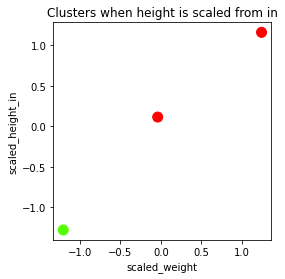

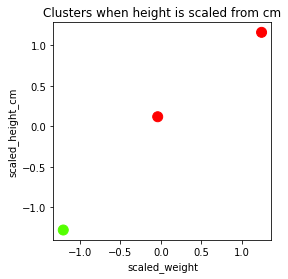

,height_in,height_cm,weight_pounds,"cluster (pound, in)","cluster (pound, cm)",scaled_height_in,scaled_height_cm,scaled_weight,"cluster (pound, scaled_in)","cluster (pound, scaled_cm)"
Ann,63,160.0,150,0,0,-1.278724,-1.279834,-1.204849,1,1
Bob,67,170.2,160,0,1,0.116248,0.118842,-0.038866,0,0
Cecil,70,177.8,171,1,1,1.162476,1.160992,1.243715,0,0


In [ ]:
for incm in ["in", "cm"]:

    clust = KMeans(n_clusters=2, random_state=10)

    df_abc[f"cluster (pound, scaled_{incm})"] = clust.fit_predict(df_abc[[f"scaled_height_{incm}", "scaled_weight"]])
    ax = df_abc.plot.scatter("scaled_weight", f"scaled_height_{incm}", 
                             c=f"cluster (pound, scaled_{incm})", cmap="prism", colorbar=False,
                             s=100, title=f"Clusters when height is scaled from {incm}")
    ax.set_aspect("equal")
    plt.show()

display(df_abc)

Observe how
* Scaling reflects that the in and cm columns encode the same height.
* Clusters are now consistent.
  * Note that the actual label number (and thus, on the plot, colour) of the clusters is up to chance (unless we set the random seed as we do here). It's the membership of the clusters that matters. (Contrast this with *classification* where labels do matter.)


> Plotting hint: You can choose your own [colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html).


## Centimeters vs meters

A variable with much larger numeric values will determine the clusters.

Let's generate some random samples that are rectangles, with one side given in cm, the other in m.

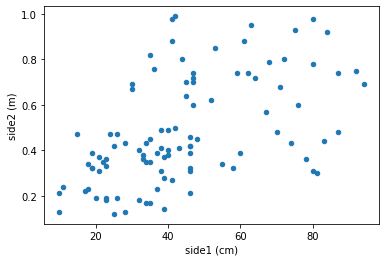

In [ ]:
import numpy as np

np.random.seed(10)
## generate some random rectangle data:
num_of_rectangles = 50
## two sides, side_1 in cm's, side_2 in meters
side_1 = np.concatenate([np.random.randint(10, 50, num_of_rectangles),
                         np.random.randint(30, 100, num_of_rectangles),])
side_2 = np.concatenate([np.random.randint(10, 50, num_of_rectangles),
                         np.random.randint(30, 100, num_of_rectangles),])  / 100
## X contains (side1, side2) pairs
X = list(zip(side_1, side_2))
df_rect = pd.DataFrame(X, columns=["side1 (cm)", "side2 (m)"])

## plot our rectangles in the side 1 - side 2 space
df_rect.plot.scatter(*df_rect.columns);

Clusters influenced by the variable with numbers that are larger by two orders of magnitude.

> Hint: Remember to pay attention to the scale of the plots when interpreting them. We here don't enforce equal aspect!

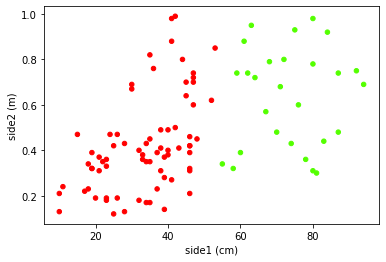

In [ ]:
clust = KMeans(n_clusters=2)
df_rect["cluster (cm, m)"] = clust.fit_predict(df_rect[["side1 (cm)", "side2 (m)"]])

df_rect.plot.scatter(*df_rect.columns[:2], c=df_rect.columns[2], cmap="prism", colorbar=False);

The same plot with equal aspect...


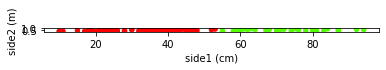

In [ ]:
print("The same plot with equal aspect...")
ax = df_rect.plot.scatter(*df_rect.columns[:2], c=df_rect.columns[2], cmap="prism", colorbar=False);
ax.set_aspect("equal")
plt.show()

In contrast, clusters after scaling...

In [ ]:
## get scaled values
scaler = preprocessing.StandardScaler()
df_rect.loc[:,["side1 (scaled)", "side2 (scaled)"]] = scaler.fit_transform(df_rect[["side1 (cm)", "side2 (m)",]])

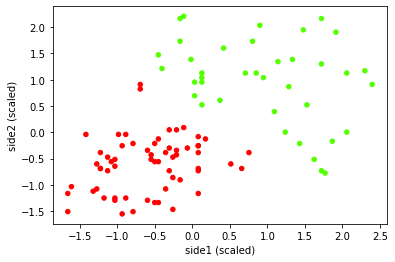

In [ ]:
clust = KMeans(n_clusters=2)
df_rect["cluster (scaled)"] = clust.fit_predict(df_rect[["side1 (scaled)", "side2 (scaled)"]])

df_rect.plot.scatter("side1 (scaled)", "side2 (scaled)", c="cluster (scaled)", cmap="prism", colorbar=False);

Observe how the dividing line went from vertical (=clusters divided along just one dimension) to slanted (=interaction of two dimensions in dividing clusters).